# Filtrando ruido con filtros adaptativos

## Librerias

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [3]:
IMAGES_DIR = '../resources/images/denoising'

## Cargar imágen

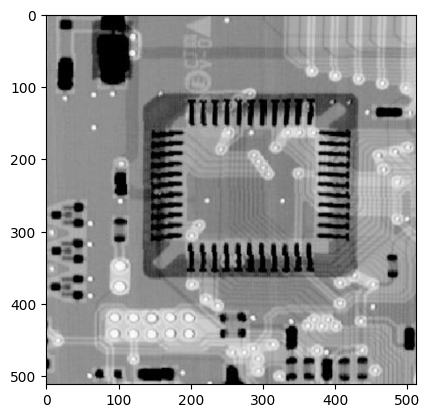

In [4]:
# cargar imagen y convertir a escala de grises
image = cv.imread(f'{IMAGES_DIR}/xray_circuit.tif')
imgray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
imgray = cv.resize(imgray, (512,512))
plt.imshow(imgray, cmap='gray')
plt.show()

# **Reto No. 1: Implementa el filtro adaptativo de ruido local**

In [5]:
def sampler(source, pixel_core, padding_core):
    lower_lim = pixel_core[0] - padding_core
    upper_lim = pixel_core[0] + padding_core
    left_lim = pixel_core[1] - padding_core
    right_lim = pixel_core[1] + padding_core

    return source[lower_lim:(upper_lim + 1), left_lim:(right_lim + 1)]

def adpt_local(image, patch_size=1):
    height, width = image.shape
    var_img = np.var(image)
    output = np.ones(image.shape)

    core_rows = list(range(height))[1:-1]
    core_columns = list(range(width))[1:-1]
    for row in range(height):
        for column in range(width):
            pixel = image[row, column]
            core = [core_rows[row], core_columns[column]]
            window = sampler(image, core, patch_size)
            output[row, column] = pixel - (var_img / np.var(window)) * (pixel - np.mean(window))

    return output

# **Reto No. 2: Implementa el filtro adaptativo de la mediana**

In [19]:
def z_params(patch):
    x_sz, y_sz = patch.shape
    z_mid = patch[x_sz // 2, y_sz // 2]
    return [np.min(patch), np.max(patch), np.median(patch), z_mid]

def adpt_median_step(img, pixel_pos, size_min=3, size_max=11):
    new_pixel = 0
    for sz in range(size_min, size_max + 1, 2):
        padding = sz // 2
        pad_image = np.pad(image, padding, mode = "reflect")

        x, y = pixel_pos
        core_wndw = [x + padding, y + padding]
        window = sampler(pad_image, core_wndw, padding)
        
        z_min, z_max, z_median, z_mid = z_params(window)
        
        is_levelA = True
        if is_levelA:
            # Level A conditions.
            if z_min < z_median < z_max:
                is_levelA = False
            elif sz < size_max:
                continue
            else:
                print(f'Reach size max in {pixel_pos}')
                new_pixel = z_median
                break
        if not is_levelA:
            # Level B conditions.
            if z_min < z_mid < z_max:
                new_pixel = z_mid
            else:
                new_pixel = z_median
            break
    return new_pixel

In [27]:
def adpt_median(image, size_max=5):
    height, width = image.shape    
    output = np.ones(image.shape)

    for row in range(height):
        for column in range(width):
            output[row, column] = adpt_median_step(image, [row, column], size_max=size_max)
    
    return output.astype("uint8")

# **Agregando y Filtrando Ruido**

1. Ruido blanco (De lectura = Gauss)
2. Ruido Sal y Pimienta (Impulsivo)
3. Ruido de disparo (Shot noise = Poisson)


# White noise

El ruido blanco es un ruido aditivo Gaussiano que es i.i.d. de media cero. Es el modelo más común para generar imágenes de ruido. Es difícil lidiar con este tipo de ruido incluso en el dominio de la frecuencia, ya que tiene la misma intensidad en todas las frecuencias. ​

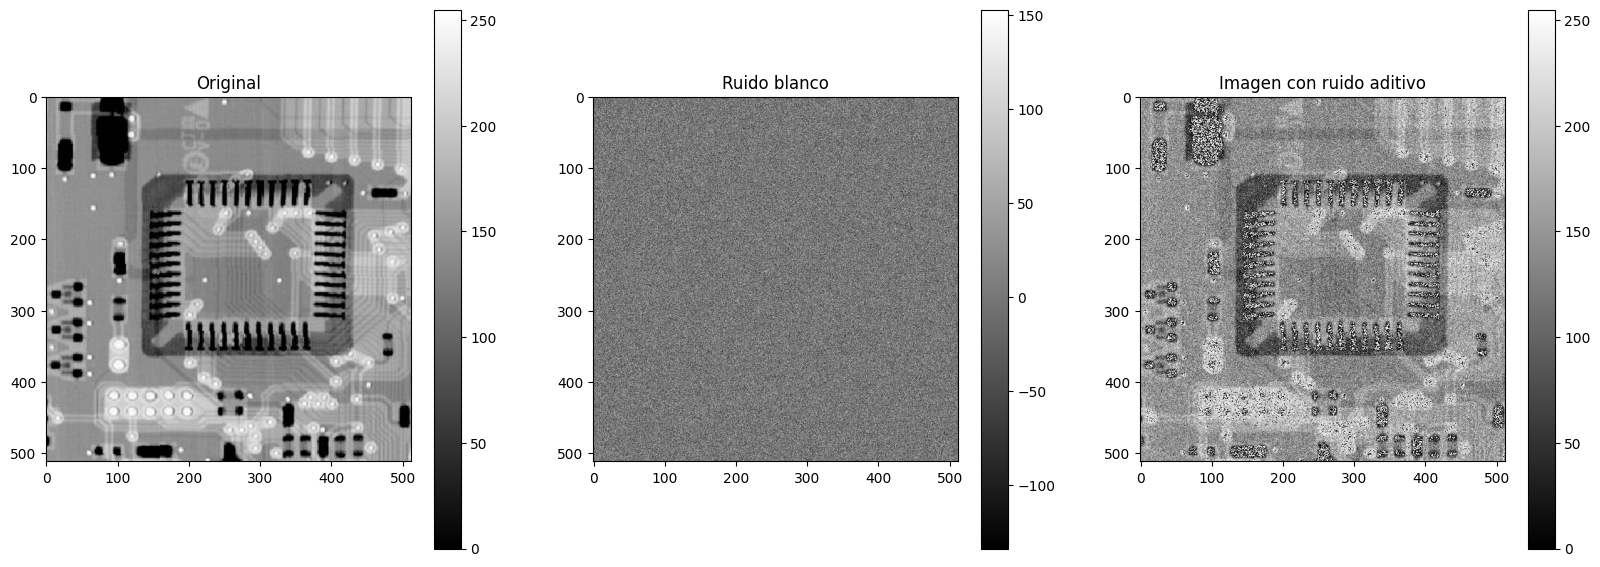

In [23]:
NOISE_STD = 30  # Desviación estándar del ruido a agregar

noise = np.random.normal(scale=NOISE_STD, size=imgray.shape)
noisy_image_White = (imgray + noise).astype('uint8')

plt.figure(figsize=(20,7))
plt.subplot(131), plt.imshow(imgray, cmap='gray'), plt.title('Original'); plt.colorbar();
plt.subplot(132), plt.imshow(noise, cmap='gray'), plt.title('Ruido blanco'); plt.colorbar();
plt.subplot(133), plt.imshow(noisy_image_White, cmap='gray'), plt.title('Imagen con ruido aditivo'); plt.colorbar();

# Salt & pepper noise

El ruido de sal y pimienta se presenta como píxeles blancos y negros que aparecen escasamente. Puede ocurrir debido al uso de instrumentos defectuosos.

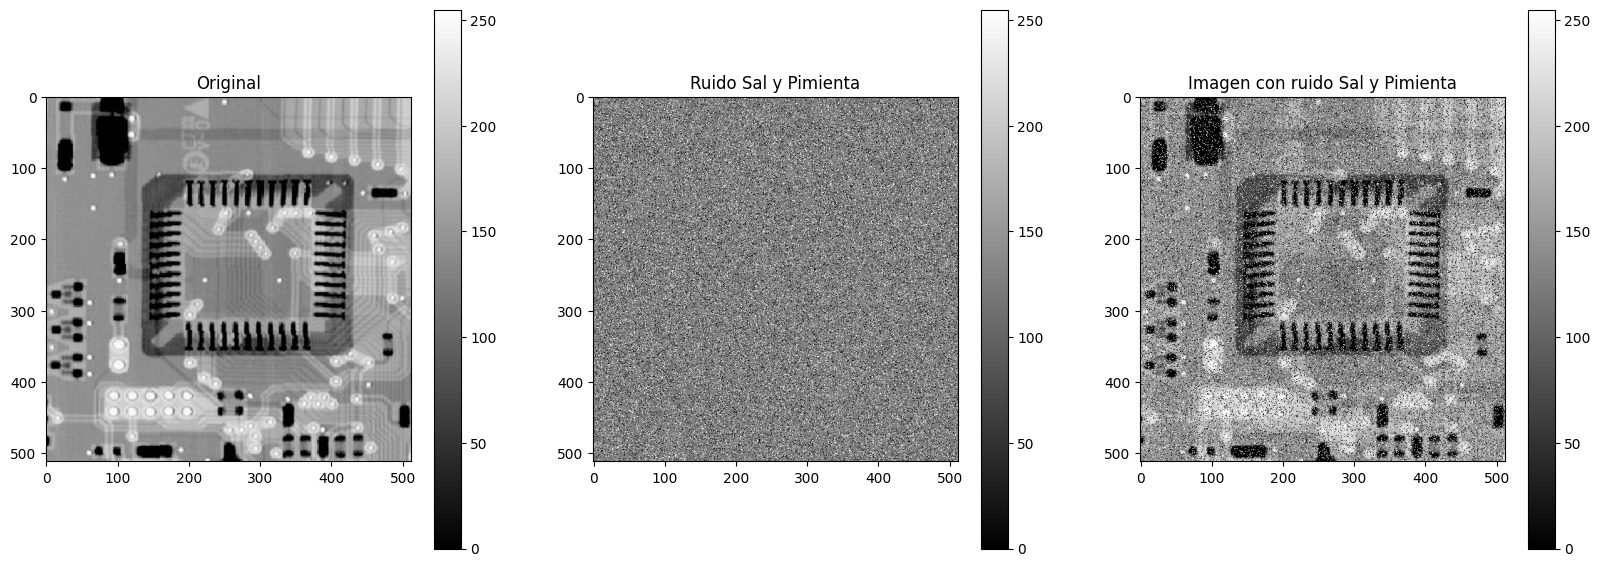

In [24]:
AMOUNT = 0.2   # proporcion de pixeles a ser afectados
SALT_VS_PEPPER = 0.5  # probabilidad de ser negro o saturado

noisy_image_SP = imgray.copy()
number_faulty_pixels = np.ceil(AMOUNT * imgray.size).astype(int)
indices = np.random.randint(0, high=512, size=(2, number_faulty_pixels))
values = np.random.binomial(1, SALT_VS_PEPPER, size=number_faulty_pixels)
noisy_image_SP[tuple(np.split(indices, 2))] = values*255

noise = np.ones(imgray.shape)*128
noise[tuple(np.split(indices, 2))] = values*255

plt.figure(figsize=(20,7))
plt.subplot(131), plt.imshow(imgray, cmap='gray'), plt.title('Original'); plt.colorbar();
plt.subplot(132), plt.imshow(noise, cmap='gray'), plt.title('Ruido Sal y Pimienta'); plt.colorbar();
plt.subplot(133), plt.imshow(noisy_image_SP, cmap='gray'), plt.title('Imagen con ruido Sal y Pimienta'); plt.colorbar();

# Shot Noise

El ruido de disparo es cualquier tipo discreto de ruido que puede modelarse como un proceso de Poisson. Ocurre en el conteo de fotones en dispositivos ópticos, debido a la naturaleza como partícula de la luz. Por tanto, este tipo de ruido se nota especialmente en condiciones de poca luz, o cuando el tiempo de exposición es corto.

No debe confundirse con el ruido oscuro *(dark noise)*, que es un ruido de Poisson aditivo.

Note que los píxeles brillantes serán más ruidosos que los oscuros, porque $E[X] = Var[X] = \lambda$.

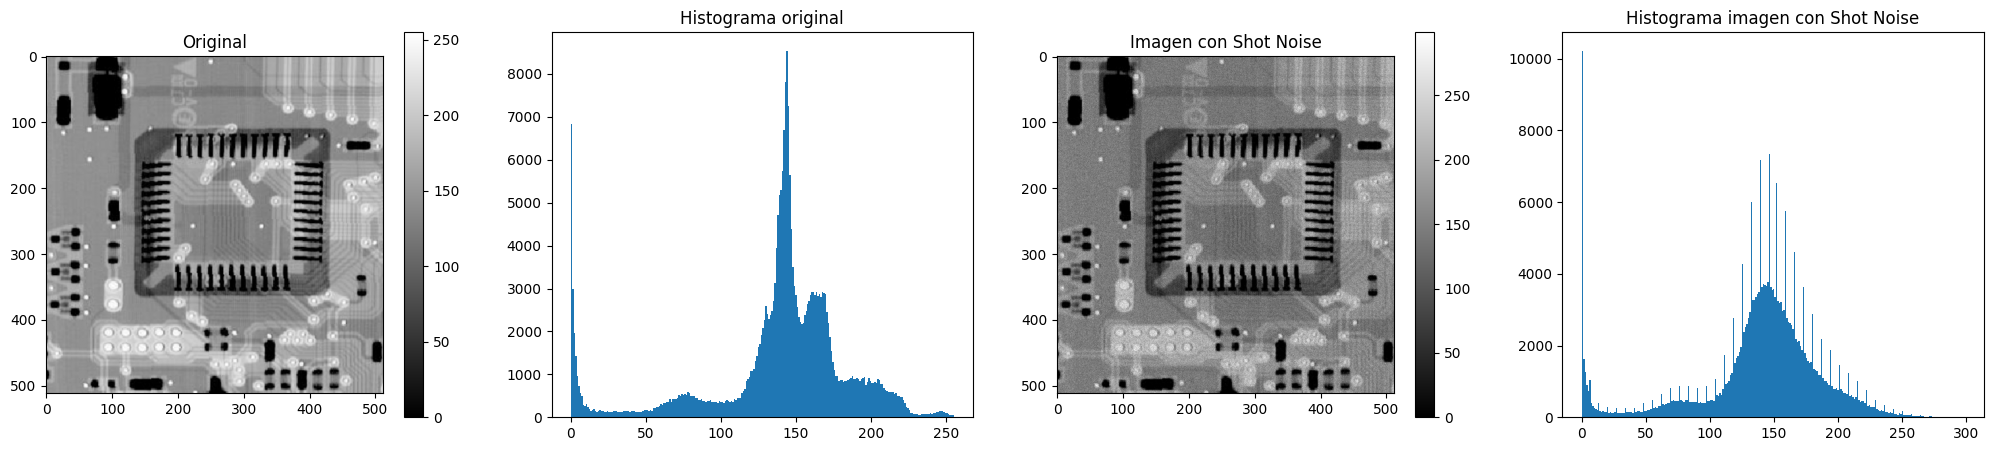

In [25]:
noisy_image_Shot = np.random.poisson(lam=imgray)

plt.figure(figsize=(25,5))
plt.subplot(141), plt.imshow(imgray, cmap='gray'), plt.title('Original'); plt.colorbar();
plt.subplot(142), plt.hist(imgray.ravel(), bins=256), plt.title('Histograma original');
plt.subplot(143), plt.imshow(noisy_image_Shot, cmap='gray'), plt.title('Imagen con Shot Noise'); plt.colorbar();
plt.subplot(144), plt.hist(noisy_image_Shot.ravel(), bins=256), plt.title('Histograma imagen con Shot Noise');
noisy_image_Shot = noisy_image_Shot.astype('uint8')

# Reto No. 3: Aplicar los filtros a las imagenes ruidosas y analizar los resultados

In [26]:
# Implentación de la función de cálculo de errores RMSE y MAE
def calcular_errores(img_est, img_ref):
    ''' Calcular el error cuadrático medio (RMSE) y el error absoluto medio (MAE)
    entre la imagen de referencia y la filtrada '''
    RMSE = np.sqrt(np.mean(np.power(img_ref - img_est, 2)))
    MAE = np.mean(np.abs(img_ref - img_est))

    return RMSE, MAE

## 3.1 Agrega ruido Gaussiano y Salt & Pepper y compara los resultados de los filtros calculando el RMSE y MAE. ¿Cuál es mejor removiendo el ruido? Comenta tus resultados.


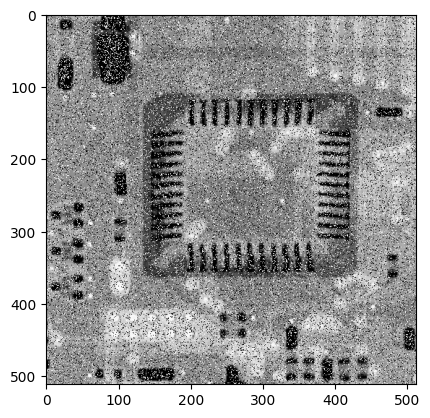

In [33]:
NOISE_STD = 1  # Desviación estándar del ruido a agregar
noise = np.random.normal(scale=NOISE_STD, size=imgray.shape)
gauss_img = (imgray + noise).astype('uint8')

AMOUNT = 0.2   # proporcion de pixeles a ser afectados
SALT_VS_PEPPER = 0.5  # probabilidad de ser negro o saturado
number_faulty_pixels = np.ceil(AMOUNT * gauss_img.size).astype(int)
indices = np.random.randint(0, high=512, size=(2, number_faulty_pixels))
values = np.random.binomial(1, SALT_VS_PEPPER, size=number_faulty_pixels)
gauss_img[tuple(np.split(indices, 2))] = values*255

plt.imshow(gauss_img, cmap='gray')
plt.show()

## Tus comentarios sobre los resultados aquí:

%Write text

## 3.2 Agrega ruido Gaussiano y Poisson, y compara los resultados de los filtros calculando el RMSE y MAE. ¿Cuál es mejor removiendo el ruido? Comenta tus resultados.

In [ ]:
# Tu codigo aqui

## Tus comentarios sobre los resultados aquí:

%Write text

## 3.3 Agrega ruido Gaussiano, Poisson y Salt & Pepper y compara los resultados de los filtros calculando el RMSE y MAE. ¿Cuál es mejor removiendo el ruido? Comenta tus resultados.

In [ ]:
# Tu codigo aqui

## Tus comentarios sobre los resultados aquí:
%Write text